In [38]:
import os
import cv2

import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 


from evaluation_metrics import *
from utils import *
from processing import apply_clahe

In [2]:
datasets = './data'
raw_dataset = f"{datasets}/raw-890/raw-890"
raw_ref_dataset = f"{datasets}/reference-890/reference-890"

def get_data_pair(idx):
    return f"{raw_dataset}/{idx}_img_.png", f"{raw_ref_dataset}/{idx}_img_.png"

In [86]:
path_raw, path_ref = get_data_pair(67)

In [143]:
img_bgr = cv2.imread(path_ref)
enhanced_img, histL, histCL = apply_clahe(path_raw, 2, (6,6))


## Gamma correction
- adjusts overall brightness in a non-linear way it lightens dark areas or darkens bright areas gently.

The corrected image is given by:

$$
I_{out} = 255 \times \left(\frac{I_{in}}{255}\right)^{\gamma}
$$

In [144]:
def apply_gamma_correction(path_raw, gamma=None):
    image = cv2.imread(path_raw)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist_before = cv2.calcHist([gray], [0], None, [256], [0, 256])

    if gamma is None:
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.log(0.5) / np.log(mean_intensity + 1e-8)
        gamma = np.clip(gamma, 0.5, 2.0)

    corrected = np.power(image / 255.0, gamma)
    corrected = np.uint8(np.clip(corrected * 255, 0, 255))

    gray_after = cv2.cvtColor(corrected, cv2.COLOR_BGR2GRAY)
    hist_after = cv2.calcHist([gray_after], [0], None, [256], [0, 256])

    return corrected, hist_before, hist_after, gamma



In [145]:
gamma_corrected_img, hist_bef_gc,hist_aft_gc, gamma = apply_gamma_correction(path_raw,0.7)
print(f"Applied gamma correction with gamma = {gamma:.2f}")

Applied gamma correction with gamma = 0.70


In [146]:
# plot_img_2_pair(
#     img_bgr,
#     enhanced_img,
#     title1="Original image",
#     title2="CLAHE Applied image",
# )

In [147]:
# plot_img_2_pair(
#     enhanced_img,
#     gamma_corrected_img,
#     title1="CLAHE image",
#     title2="Gamma on CLAHE image",
# )

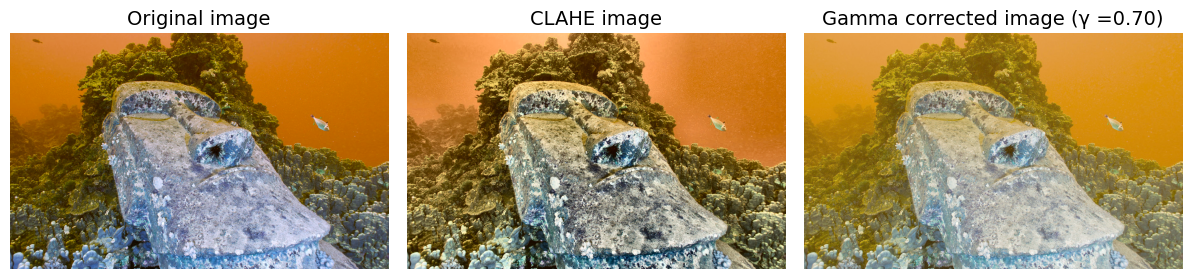

In [148]:
plot_img_3_pair(
    img_bgr,
    enhanced_img,
    gamma_corrected_img,
    title1="Original image",
    title2="CLAHE image",
    title3=f"Gamma corrected image (γ ={gamma:.2f})",
)

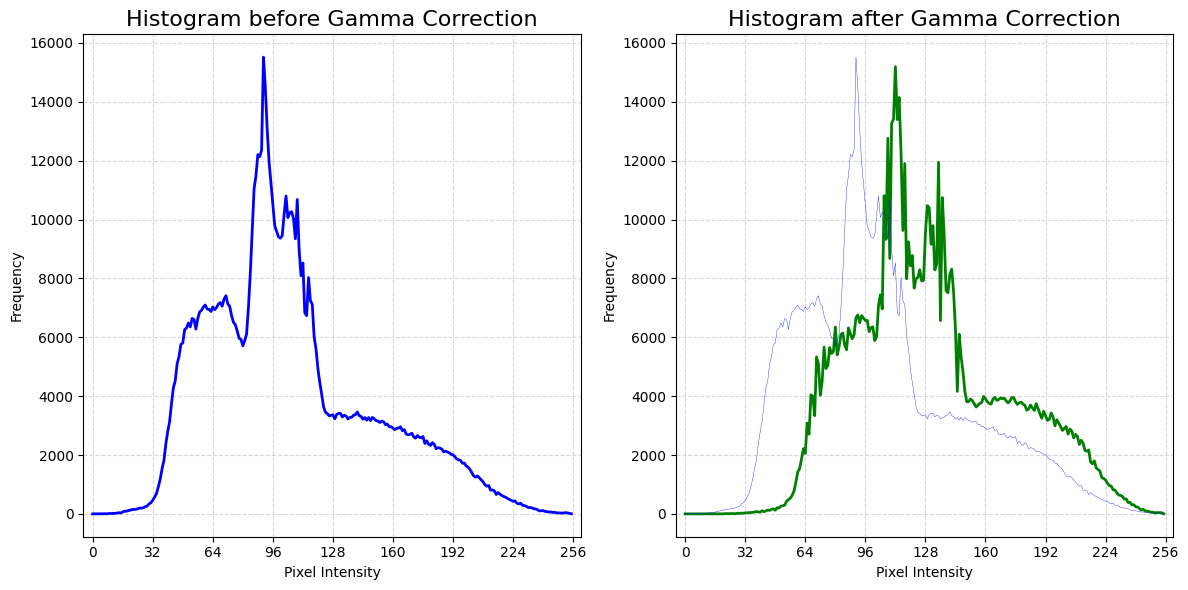

In [149]:
plot_hist_curve_2_pair(
    hist_bef_gc,hist_aft_gc,
    "Histogram before Gamma Correction",
    "Histogram after Gamma Correction",
    overlay_1_on_2 = True,
)

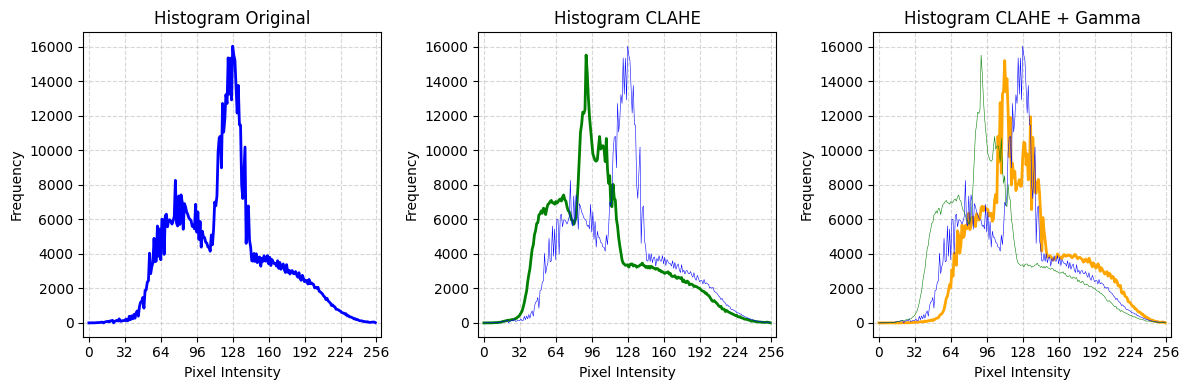

In [150]:
plot_hist_curve_3_pair(
    histL, hist_bef_gc,hist_aft_gc,
    "Histogram Original",
    "Histogram CLAHE",
    "Histogram CLAHE + Gamma",
    overlay_1_on_2 = True,
    overlay_1_on_3 = True,
    overlay_2_on_3 = True,
    overlay_alpha = 0.39,
)

In [151]:
gamma_ssim, diff_gamma = structural_similarity_index(img_bgr, gamma_corrected_img)
clahe_ssim, diff_clahe = structural_similarity_index(img_bgr, enhanced_img)
print(f"SSIM for gamma corrected {gamma_ssim:.4f}")
print(f"SSIM for clahe {clahe_ssim:.4f}")

SSIM for gamma corrected 0.8153
SSIM for clahe 0.7963


In [152]:
print(UCIQE(enhanced_img))
print(UCIQE(gamma_corrected_img))

0.31558583309459687
0.2984520038666726


In [153]:
uiqm, uicm, uism, uiconm = UIQM(enhanced_img)
print(f"uiqm {uiqm}, uism {uism}")

uiqm 0.9152779023753052, uism 0.5050767658845596


In [157]:
raw_dir = r"/Users/pritam/Desktop/DIP/Project/DeepSea-Image-Enhancement/src/dip_project/data/raw-890/raw-890/"
ref_dir = r"/Users/pritam/Desktop/DIP/Project/DeepSea-Image-Enhancement/src/dip_project/data/reference-890/reference-890/"
raw_paths = []
ref_paths = []
for file_name in os.listdir(raw_dir):
    if file_name.endswith('.png'):
        raw_paths.append(os.path.join(raw_dir, file_name))
for file_name in os.listdir(ref_dir):
    if file_name.endswith('.png'):
        ref_paths.append(os.path.join(ref_dir, file_name))

In [158]:
gamma_ssims = []
clahe_ssims = []
for raw_path, ref_path in zip(raw_paths, ref_paths):
    raw_img = cv2.imread(raw_path)
    ref_img = cv2.imread(ref_path)
    gamma_corrected_img, _,_, gamma = apply_gamma_correction(raw_path,0.7)
    gamma_ssim, _ = structural_similarity_index(ref_img, gamma_corrected_img)
    gamma_ssims.append(gamma_ssim)
    clahe_img, _,_ = apply_clahe(raw_path, 2, (6,6))
    clahe_ssim, _ = structural_similarity_index(ref_img, clahe_img)
    clahe_ssims.append(clahe_ssim)
print(f"Average SSIM for gamma corrected {np.mean(gamma_ssims):.4f}")
print(f"Average SSIM for clahe {np.mean(clahe_ssims):.4f}") 

Average SSIM for gamma corrected 0.7437
Average SSIM for clahe 0.8208


In [159]:
gamma_UIQM_scores = []
clahe_UIQM_scores = []
for raw_path in raw_paths:
    raw_img = cv2.imread(raw_path)
    gamma_corrected_img, _,_, gamma = apply_gamma_correction(raw_path,0.7)
    gamma_uiqm, _, _, _ = UIQM(gamma_corrected_img)
    gamma_UIQM_scores.append(gamma_uiqm)
    clahe_img, _,_ = apply_clahe(raw_path, 2, (6,6))
    clahe_uiqm, _, _, _ = UIQM(clahe_img)
    clahe_UIQM_scores.append(clahe_uiqm)
print(f"Average UIQM for gamma corrected {np.mean(gamma_UIQM_scores):.4f}")
print(f"Average UIQM for clahe {np.mean(clahe_UIQM_scores):.4f}")

Average UIQM for gamma corrected 0.5220
Average UIQM for clahe 0.7525


In [160]:
gamma_uciqe_scores = []
clahe_uciqe_scores = []
for raw_path in raw_paths:
    raw_img = cv2.imread(raw_path) 
    gamma_corrected_img, _,_, gamma = apply_gamma_correction(raw_path,0.7)
    gamma_uciqe = UCIQE(gamma_corrected_img)
    gamma_uciqe_scores.append(gamma_uciqe)
    clahe_img, _,_ = apply_clahe(raw_path, 2, (6,6))
    clahe_uciqe = UCIQE(clahe_img)
    clahe_uciqe_scores.append(clahe_uciqe)
print(f"Average UCIQE for gamma corrected {np.mean(gamma_uciqe_scores):.4f}")
print(f"Average UCIQE for clahe {np.mean(clahe_uciqe_scores):.4f}")

Average UCIQE for gamma corrected 0.2161
Average UCIQE for clahe 0.2537
